In [1]:
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# Data Import

In [2]:
pict_dir = "../data/pict_push-ups-from-side/2-1.COCO-pose/"
movi_dir = "../data/movie_push-ups-from-side/2-1.COCO-pose_mod/"

print(glob.glob(pict_dir + "*"))
print(glob.glob(movi_dir + "*"))

movie_files = glob.glob(movi_dir + "*")

['../data/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/Z_estimate-error.csv']
['../data/movie_push-ups-from-side/2-1.COCO-pose_mod/IMG_7471.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose_mod/IMG_7470.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose_mod/VID_20171128_174622.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose_mod/VID_20171128_174702.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose_mod/IMG_4936.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose_mod/IMG_4937.csv']


## データの選定
~~幡山さんの写ってる動画がよく関節位置が取れていて良さそうだからこれに絞る~~  
全員分のデータを合わせて訓練データにする

Load

In [3]:
data = np.loadtxt(pict_dir + "0_up.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
up_data = data[:, :-1].astype(float)
img_name = data[:, -1]

# filter_img = [img in pict_up_file for img in img_name]
# up_data = up_data[filter_img, :]

print(up_data.shape)

(48, 54)


In [4]:
data = np.loadtxt(pict_dir + "1_down.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
down_data = data[:, :-1].astype(float)
img_name = data[:, -1]

# filter_img = [img in pict_down_file for img in img_name]
# down_data = down_data[filter_img, :]

print(down_data.shape)

(41, 54)


In [5]:
csvs = []
names = []
movie_bases = []
for mf in movie_files:
    try:
        df = pd.read_csv(mf, header=None, dtype=str).iloc[:, range(54)].astype(float).values
        csvs.append(df)
        name = np.loadtxt(mf, delimiter=",", usecols=54, dtype=str)
        names.append(name)
        movie_bases.append(mf[mf.rindex("/")+1:mf.rindex(".csv")])
    except (ValueError, IndexError):
        print(mf)
        continue

print(len(csvs))
movie_data = np.vstack(csvs)
movie_names = np.hstack(names)

for i, s in enumerate(movie_names):
    movie_names[i] = s[2:-1]

6


In [6]:
print([len(n) for n in names])
print([len(n) for n in csvs])

[820, 738, 666, 752, 780, 861]
[820, 738, 666, 752, 780, 861]


In [7]:
print(up_data.shape)
print(down_data.shape)
print(movie_data.shape)

(48, 54)
(41, 54)
(4617, 54)


In [8]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    conf_r = np.mean(data[:, right*3 + 2], axis=1)
    conf_l = np.mean(data[:, left*3 + 2], axis=1)
    conf = np.vstack([conf_r, conf_l])
    argmax_conf = np.argmax(conf, axis=0)
    max_conf = np.max(conf, axis=0)
    
    pos_r = np.dstack([data[:, right*3], data[:, right*3+1]]).reshape(-1, 6)
    pos_l = np.dstack([data[:, left*3], data[:, left*3+1]]).reshape(-1, 6)
    pos = np.hstack([pos_r, pos_l])
    print(argmax_conf)
    out = pos[argmax_conf*6:argmax_conf*6+6]
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

def normalizePos(pos, all_data):
    '''
    Assuming...
    pos: n_data x (2*n_selected_joint); x, y, ...
    all_data: n_data x (3*n_all_joint); x, y, conf, ...
    '''
    N, d = pos.shape
    N, D = all_data.shape
    pos = pos.reshape(N, d//2, 2)
    all_data = all_data.reshape(N, D//3, 3)[:, :, 0:2]
    xy_max = np.max(all_data, axis=1)[:, np.newaxis]
    xy_min = np.min(all_data, axis=1)[:, np.newaxis]
    out = (pos - xy_min)/(xy_max - xy_min)
    return out.reshape(N, d)

# def normalizePos(pos, all_data):
#     '''
#     Assuming...
#     pos: n_data x (2*n_selected_joint); x, y, ...
#     all_data: n_data x (3*n_all_joint); x, y, conf, ...
#     '''
#     rows, cols = pos.shape
#     all_rows, all_cols = all_data.shape
#     if all_cols % 3 != 0:
#         print("all_data needs 3*n cols")
#         return
#     x = all_data[:, range(0, 54, 3)]
#     y = all_data[:, range(1, 54, 3)]
#     conf = all_data[:, range(2, 54, 3)]
    
#     x_max = np.max(x, axis=1, keepdims=True)
#     x[conf < 0.05] = np.inf
#     x_min = np.min(x, axis=1, keepdims=True)
    
#     y_max = np.max(y, axis=1, keepdims=True)
#     y[conf < 0.05] = np.inf
#     y_min = np.min(y, axis=1, keepdims=True)
    
#     pos_max = np.tile(np.reshape(np.dstack([x_max, y_max]), (-1, 2)), (1, cols//2))
#     pos_min = np.tile(np.reshape(np.dstack([x_min, y_min]), (-1, 2)), (1, cols//2))
    
#     # return pos / (pos_max - pos_min)
#     return (pos - pos_min)/(pos_max - pos_min)

def deleteLowConf(pos, data):
    '''
    data: data_num x (2*joint_num)
    '''
    N, d = pos.shape
    mask = np.ones(N, dtype=bool)
    mask[np.any(pos == 0., axis=1)] = False
    return pos[mask], data[mask], mask

def makeFeature(pos):
    n, d = pos.shape
    d //= 2
    _pos = pos.reshape(n, d, 2)
    # カーネル行列を作る時に使うテクニックのテンソル版
    a = np.repeat(np.sum(_pos**2, axis=2)[:, :, np.newaxis], d, axis=2)
    b = np.transpose(a, (0, 2, 1))
    c = np.einsum("ijk,ilk->ijl", _pos, _pos)
    out = a - 2*c + b
    i1, i2 = np.triu_indices(d, k=1)
    out = out[np.repeat(np.arange(n), [d]), np.tile(i1, n), np.tile(i2, n)].reshape(n, d*(d-1)//2)
    return out

In [9]:
right = np.arange(2, 5)
(up_pos, up_data, up_mask), up_conf = deleteLowConf(extractJointPos(up_data, right), up_data), extractJointConf(up_data, right)
(down_pos, down_data, down_mask), down_conf = deleteLowConf(extractJointPos(down_data, right), down_data), extractJointConf(down_data, right)
(movie_pos, movie_data, movie_mask), movie_conf = deleteLowConf(extractJointPos(movie_data, right), movie_data), extractJointConf(movie_data, right)

In [10]:
nm_up_pos = normalizePos(up_pos, up_data)
nm_down_pos = normalizePos(down_pos, down_data)
nm_movie_pos = normalizePos(movie_pos, movie_data)

In [11]:
# 肩を原点にして特徴量にする
nm_up_pos = nm_up_pos[:, 2:] - np.tile(nm_up_pos[:, :2], (1, 2))
nm_down_pos = nm_down_pos[:, 2:] - np.tile(nm_down_pos[:, :2], (1, 2))
nm_movie_pos = nm_movie_pos[:, 2:] - np.tile(nm_movie_pos[:, :2], (1, 2))

In [12]:
# 距離を特徴量にする
nm_up_pos = makeFeature(nm_up_pos)
nm_down_pos = makeFeature(nm_down_pos)
nm_movie_pos = makeFeature(nm_movie_pos)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (66,) (33,) (33,) 

In [13]:
nm_movie_names = movie_names[movie_mask]

# 半教師あり学習（新正規化）

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [14]:
test_ratio = 1.
train_max_index = int(nm_movie_pos.shape[0]*(1 - test_ratio))
train_nm_movie_pos = nm_movie_pos[:train_max_index, :]
test_nm_movie_pos = nm_movie_pos[train_max_index:, :]

train_nm_movie_names = nm_movie_names[:train_max_index]
test_nm_movie_names = nm_movie_names[train_max_index:]

train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
test_data = test_nm_movie_pos
print(train_data.shape)

(53, 4)


In [15]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int),
    -1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(53,)


In [16]:
clf = LabelSpreading()
clf.fit(train_data, labels)

LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=30, n_jobs=1,
        n_neighbors=7, tol=0.001)

In [17]:
pred_label = clf.predict(test_data)

In [18]:
print(np.sum(pred_label == 0))
print(np.sum(pred_label == 1))

1045
1731


In [19]:
movie_bases

['IMG_7471',
 'IMG_7470',
 'VID_20171128_174622',
 'VID_20171128_174702',
 'IMG_4936',
 'IMG_4937']

In [20]:
bk_movie_names = [[] for _ in movie_bases]

for mn in nm_movie_names:
    flag = False
    for i, mb in enumerate(movie_bases):
        if mb in mn:
            bk_movie_names[i].append(mn)
            flag = True
            break
    if not flag:
        print(mn)

In [21]:
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"

test_movie_names = nm_movie_names[train_max_index:]
test_img_files = []
for mn in test_movie_names:
    filename = mn[:mn.index(".")]
    test_img_files.append(imgs_pardir + filename + "/" + mn)

In [22]:
len(test_img_files)

2776

<IPython.core.display.Javascript object>


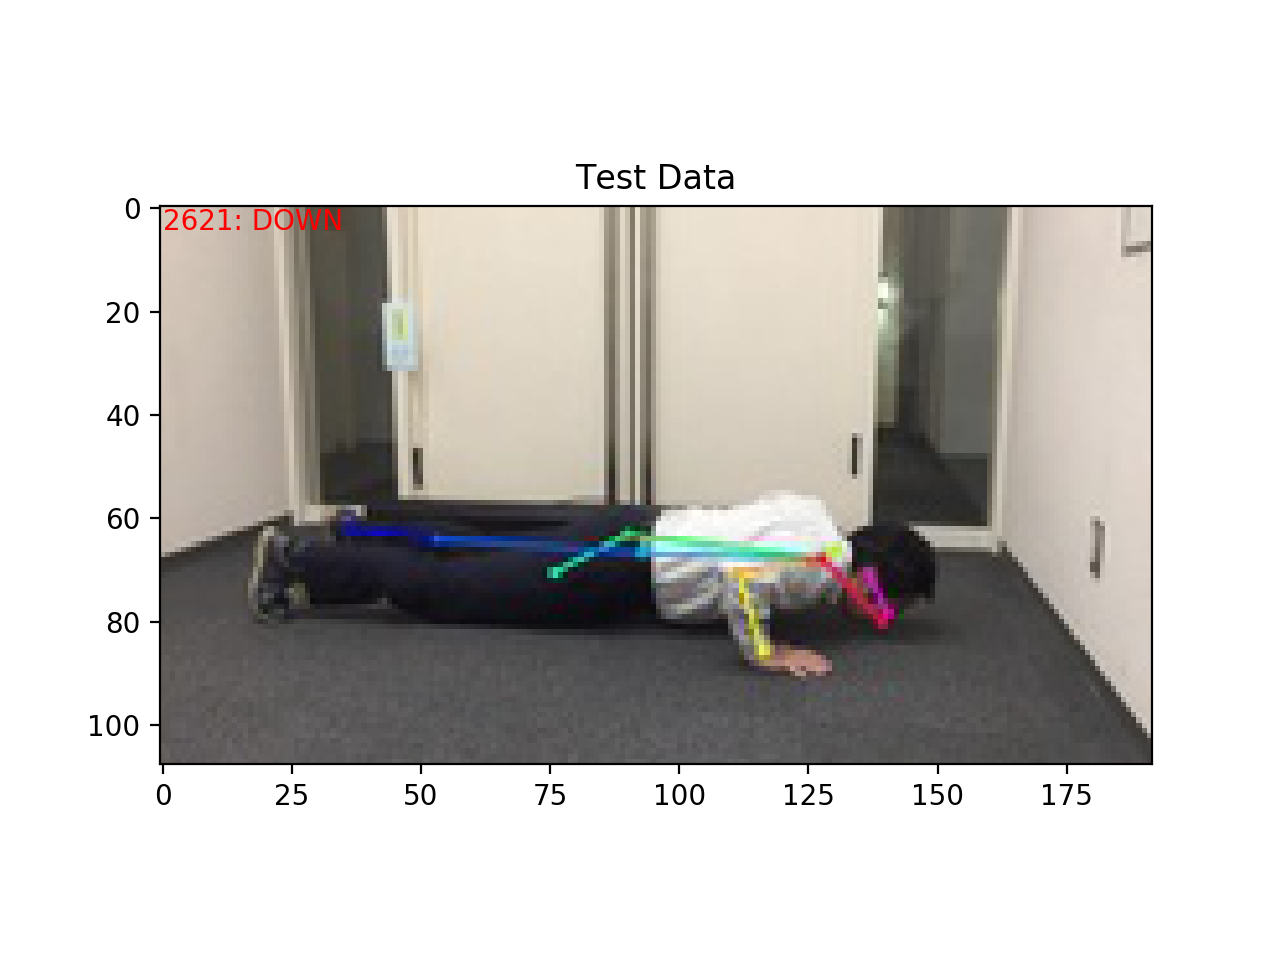

In [23]:
%matplotlib nbagg

fig = plt.figure()
plt.title("Test Data")
ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = ("%03d: " % i) + ("UP" if pred_label[i] == 1 else "DOWN")
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()